# Training an Agent to play Super Mario with Offline Learning
---

In this exercise you will learn how to use offline learning to train a neural network to play Super Mario.
Its performance will then be compared with the results from the Q-Learning exercise. 

## 0. Setup

### Requirements
 - Java 8 (or later) runtime environment
 - Python 3.6 (or later)
 - Microsoft Visual C++ 14.0 (or later)

You will be provided with both the .jar and the gym-marioai python package.

### Installation
To setup this exercise we will use Pipenv.
If you do not have pipenv installed please do so by running:

``pip install --user pipenv``

After that please run (if not already done)

``pipenv install`` and
``pipenv run start``.


in the root directory to start the Jupyter notebook containing the exercise.

(pipfile set to python version 3.6 by default, can be edited if needed)

In [1]:
# Setup the imports. Run this cell again if you encounter any import errors.
import copy
import numpy as np
import pathlib

from d3rlpy.algos import DQN
import d3rlpy.dataset
from d3rlpy.dataset import MDPDataset, ReplayBuffer
from d3rlpy.metrics import EnvironmentEvaluator
from d3rlpy.ope import FQE
# from d3rlpy.metrics.scorer import evaluate_on_environment
from sklearn.model_selection import train_test_split

from gym_setup import Env
from controller import GamepadController, KeyboardController
from data.datasets.getDatasets import getDataset
import matplotlib.pyplot as plt

%load_ext tensorboard
%set_env PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

env: PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python


## 1. Generating data
First, you will have to generate some data for the neural network to train with.

### Level
The level we will be using for this exercise will be a very easy one to minimize the training time.

However, if you would like to try different levels, we encourage you to do so by changing the ``level`` variable below to a different one from the ``levels`` folder.

In [2]:
# Setup global variables
level = pathlib.Path("levels", "OneCliffLevel.lvl").resolve()
dataset_path = pathlib.Path("data", "datasets", level.stem + ".h5").resolve()
dataset_path_rand = pathlib.Path("data", "datasets", level.stem + ".random.h5").resolve()

### 1.1 Player generated data.

![Mario](https://media1.giphy.com/media/aX0RqLt2ARSW4/giphy.gif?cid=ecf05e47fnkts3fqh25tj9v8noh9vnccwo4x0ey4zpdxc7ft&rid=giphy.gif&ct=g)


To achieve the best possible results, the training algorithm needs the best possible data. In this case that means player generated data.


You will have the most fun playing with a USB-Controller but if you have none, you can set the following variable to ``False`` to use the keyboard:

In [4]:
# Don't forget to run me
USE_GAMEPAD = False

### Controls
|            	| Keyboard    	| Xbox       	| Playstation 	|
|------------	|-------------	|------------	|-------------	|
| Jump       	| S           	| A          	| X           	|
| Sprint     	| A           	| B          	| O           	|
| Move Right 	| Arrow Right 	| Dpad Right 	| Dpad Right  	|
| Move Left  	| Arrow Left  	| Dpad Left  	| Dpad Left   	|
| Duck       	| Arrow Down  	| Dpad Down  	| Dpad Down   	|

To start the game run the next cell. If you think you have enough data just close the game window and move on to the next cell.

Note: We have pregenerated some training data for your convenience which will be used in addition to your data to train the model.
If you want to train with your own data only, go ahead and delete the data from ``exercise_offline_rl\data\datasets``.

In [8]:
# Let's play!
try:
    env_play = Env(visible=True, level=str(level)).env
    
    if USE_GAMEPAD:
        controller = GamepadController(env_play)
    else:
        controller = KeyboardController(env_play)
    while True:
        observation,_ = env_play.reset()
        
        done = False
        action = controller.read()

        observations = [observation]
        
        actions = [action]
        # No reward at first time step, because no action was taken yet
        rewards = [0]
        terminals = [done]

        while not done:
            observation, reward, done, truncated, info = env_play.step(action)
            
            action = controller.read()

            observations.append(observation)
            actions.append(action)
            rewards.append(reward)
            terminals.append(done)

        dataset = None
        if dataset_path.exists():
            # NOTE: is this the correct type of buffer?
            # see https://d3rlpy.readthedocs.io/en/latest/references/dataset.html
            with dataset_path.open("rb") as dataset_file:
                dataset: ReplayBuffer = ReplayBuffer.load(dataset_file, d3rlpy.dataset.InfiniteBuffer())
                dataset.append_episode(d3rlpy.dataset.components.Episode(np.asarray(observations), np.asarray(actions)[:,np.newaxis],
                               np.asarray(rewards)[:,np.newaxis], done))
        else:
            dataset = MDPDataset(np.asarray(observations), np.asarray(actions)[:,np.newaxis],
                                 np.asarray(rewards)[:,np.newaxis], np.asarray(terminals))
        with open(dataset_path, "w+b") as f:
            dataset.dump(f)
        
except ConnectionResetError:
    print("Done")

Running on port 50320
(200, 4)
Done


### 1.2 Randomly generated data (optional)
To complement the player generated data, it is possible to also generate some random data for the algorithm to train with.

In [14]:
# Generate random data
EPISODES = 10 # <--- increase if you want more random data. More data might slow down the training process.

env_rand = Env(visible=False, level=str(level)).env

for episode in range(EPISODES):
    observation, _ = env_rand.reset()
    done = False
    action = env_rand.action_space.sample()
    
    observations = [observation]
    actions = [action]
    # No reward at first time step, because no action was taken yet
    rewards = [0]
    terminals = [done]

    while not done:
        observation, reward, done, truncated, info = env_rand.step(action)
        action = env_rand.action_space.sample()

        observations.append(observation)
        actions.append(action)
        rewards.append(reward)
        terminals.append(done)

    dataset = None
    if dataset_path_rand.exists():
        # NOTE: is this the correct type of buffer?
        # see https://d3rlpy.readthedocs.io/en/latest/references/dataset.html
        with dataset_path_rand.open("rb") as dataset_file:
            dataset: ReplayBuffer = ReplayBuffer.load(dataset_file, d3rlpy.dataset.InfiniteBuffer())
            dataset.append_episode(d3rlpy.dataset.components.Episode(np.asarray(observations), np.asarray(actions)[:,np.newaxis],
                           np.asarray(rewards)[:,np.newaxis], done))
    else:
        dataset = MDPDataset(np.asarray(observations), np.asarray(actions)[:,np.newaxis],
                             np.asarray(rewards)[:,np.newaxis], np.asarray(terminals))
    dataset.dump(dataset_path_rand)

print("Done!")

Running on port 58016
(200, 4)
Done!


## 2. Use the generated data to train a policy
Now that you have generated some data for the neural network to train with, let's begin with the training.
For the purpose of this exercise we will use the Offline RL Python library [d3rlpy](https://github.com/takuseno/d3rlpy).



### 2.1 Choosing an algorithm
![DQN](https://raw.githubusercontent.com/koerners/marioai/master/exercise_offline_rl/data/jupyter/dqn.PNG)

#### Why we chose DQN
The Deep Q-Network approach is known to have been able to achieve human-level control in Atari games, and it is able to learn successful policies directly from high-dimensional sensory inputs (like pixels) using end-to-end reinforcement learning which makes it ideal for our purpose. [[1]](https://www.nature.com/articles/nature14236) 

It uses data collected from an environment to learn and train without interacting with it.

For more information on DQN, please refer to [this paper](https://www.nature.com/articles/nature14236).



### 2.2 Setup the training
First we set the training parameters.
Most of these are fairly optimized but feel free to experiment.

In [17]:
# Training parameters
n_epochs = 10 # <--- change here if you want to train more / less
n_steps_per_epoch = 1000
test_size = 0.1 # percentage of episodes not used for training

# DQN parameters
learning_rate = 0.0003 # to what extent the agent overrides old information with new information
gamma = 0.99 # discount factor, how important future rewards are
target_update_interval = 3000 # interval of steps that the agent uses to update target network
batch_size = 2 # size of training examples utilized in one iteration
use_gpu = False # usage of gpu to train

### 2.3 Training time!

If you want to track the training with tensorboard, run the following cell.

In [10]:
# Start tensorboard 
%tensorboard --logdir runs

Launching TensorBoard...

To start the training run the next cell: 

In [5]:
dataset =getDataset()
# train_episodes, test_episodes = train_test_split(dataset.episodes, test_size=test_size)
print(len(dataset.episodes))

print(dataset.episodes[0].observations[0].shape)

dqn = d3rlpy.algos.DQNConfig(learning_rate=learning_rate, gamma=gamma,
          target_update_interval=target_update_interval,
          batch_size=batch_size).create()
test_episodes = dataset.episodes[:30]

# set environment in scorer function
env_train = Env(visible=False, level=str(level)).env
dqn.build_with_dataset(dataset)
env_evaluator  = EnvironmentEvaluator(env_train)

# evaluate algorithm on the environment
name = 'DQN_marioai_%s_%s_%s_%s_%s' % (level.stem, gamma, learning_rate, target_update_interval, n_epochs)
model_file = pathlib.Path("data", "models", name + ".pt")
currentMax = -100000
dqn_max = copy.deepcopy(dqn)

fitter = dqn.fitter(
   dataset,
   n_steps = n_steps_per_epoch * n_epochs,
   n_steps_per_epoch=n_steps_per_epoch,
  evaluators={'td_error': d3rlpy.metrics.TDErrorEvaluator(test_episodes),
              'value_scale': d3rlpy.metrics.AverageValueEstimationEvaluator(test_episodes),
              'environment': env_evaluator },
  show_progress = False
)
dataset.trajectory_slicer
for epoch, metrics in fitter:
    if metrics.get("environment") > currentMax:
        currentMax = metrics.get("environment")
        dqn_max.copy_q_function_from(dqn)
    else:
        dqn.copy_q_function_from(dqn_max)
    dqn.save_model(model_file)
    if currentMax > 100:
        # For the purpose of the exercise the training will stop if the agent manages to complete the level
        print("A suitable model has been found.")
        break

D:\marioai\exercise_offline_rl\data\datasets\OneCliffLevel.h5
D:\marioai\exercise_offline_rl\data\datasets\RoughTerrainLevel.h5
155
(800,)
Running on port 59662


d:\marioai\marioenv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment Marioai-v0 is out of date. You should consider upgrading to version `v2`.
  logger.warn(


(200, 4)
observation_shape:  (800,)
dataset_info.action_size:  13
2023-08-23 23:38:23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('int8')], shape=[(800,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=13)
2023-08-23 23:38:23 [info     ] Directory is created at d3rlpy_logs\DQN_20230823233823
2023-08-23 23:38:23 [warning  ] Skip building models since they're already built.
2023-08-23 23:38:23 [info     ] Parameters                     params={'observation_shape': [800], 'action_size': 13, 'config': {'type': 'dqn', 'params': {'batch_size': 2, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0003, 'optim_factory': {'type': 'adam', 'params': {'betas':

d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


2023-08-23 23:38:29 [info     ] DQN_20230823233823: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0002329986095428467, 'time_algorithm_update': 0.005256407499313355, 'loss': 1.1607204995023204, 'time_step': 0.00553724217414856, 'td_error': 235.89865483331454, 'value_scale': 0.9956269038195864, 'environment': 34.0} step=1000
2023-08-23 23:38:29 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20230823233823\model_1000.d3
2023-08-23 23:38:36 [info     ] DQN_20230823233823: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.00022431612014770508, 'time_algorithm_update': 0.005786659240722657, 'loss': 1.0110202380386764, 'time_step': 0.0060577945709228516, 'td_error': 235.69688544187534, 'value_scale': 0.9502424138636024, 'environment': 25.0} step=2000
2023-08-23 23:38:36 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20230823233823\model_2000.d3
2023-08-23 23:38:43 [info     ] DQN_20230823233823: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch':

In [17]:
dataset =getDataset() 
print(len(dataset.episodes))

ddqn = d3rlpy.algos.DoubleDQNConfig(learning_rate=learning_rate, gamma=gamma,
          target_update_interval=target_update_interval,
          batch_size=batch_size).create()
test_episodes = dataset.episodes[:30]
# set environment in scorer function
env_train = Env(visible=False, level=str(level)).env
ddqn.build_with_dataset(dataset)
env_evaluator  = EnvironmentEvaluator(env_train)

# evaluate algorithm on the environment

name = 'DDQN_marioai_%s_%s_%s_%s_%s' % (level.stem, gamma, learning_rate, target_update_interval, n_epochs)
model_file = pathlib.Path("data", "models", name + ".pt")
currentMax = -100000
ddqn_max = copy.deepcopy(ddqn)

fitter = ddqn.fitter(
   dataset,
   n_steps = n_steps_per_epoch * n_epochs,
   n_steps_per_epoch=n_steps_per_epoch,
  evaluators={'td_error': d3rlpy.metrics.TDErrorEvaluator(test_episodes),
              'value_scale': d3rlpy.metrics.AverageValueEstimationEvaluator(test_episodes),
              'environment': env_evaluator },
  show_progress = False
)

for epoch, metrics in fitter:
    if metrics.get("environment") > currentMax:
        currentMax = metrics.get("environment")
        ddqn_max.copy_q_function_from(ddqn)
    else:
        ddqn.copy_q_function_from(ddqn_max)
    ddqn.save_model(model_file)
    if currentMax > 100:
        # For the purpose of the exercise the training will stop if the agent manages to complete the level
        print("A suitable model has been found.")
        break

D:\marioai\exercise_offline_rl\data\datasets\OneCliffLevel.h5
D:\marioai\exercise_offline_rl\data\datasets\RoughTerrainLevel.h5
155
Running on port 63928
(200, 4)
observation_shape:  (800,)
dataset_info.action_size:  13
2023-08-23 23:24:26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('int8')], shape=[(800,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=13)
2023-08-23 23:24:26 [info     ] Directory is created at d3rlpy_logs\DoubleDQN_20230823232426
2023-08-23 23:24:26 [warning  ] Skip building models since they're already built.
2023-08-23 23:24:26 [info     ] Parameters                     params={'observation_shape': [800], 'action_size': 13, 'config': {'type': 'double_dqn', 'params': {'batch_size': 2, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s

In [11]:
dataset =getDataset()
print(len(dataset.episodes))

sac = d3rlpy.algos.DiscreteSACConfig( actor_learning_rate=0.0003, 
                                     critic_learning_rate=0.0003,
                                     temp_learning_rate = 0.0003,
                                     gamma=gamma,
          batch_size=batch_size).create()
test_episodes = dataset.episodes[:30]

# set environment in scorer function
env_train = Env(visible=False, level=str(level)).env
sac.build_with_dataset(dataset)
env_evaluator  = EnvironmentEvaluator(env_train)

# evaluate algorithm on the environment
name = 'SAC_marioai_%s_%s_%s_%s_%s' % (level.stem, gamma, learning_rate, target_update_interval, n_epochs)
model_file = pathlib.Path("data", "models", name + ".pt")
currentMax = -100000
sac_max = copy.deepcopy(sac)

fitter = sac.fitter(
   dataset,
   n_steps = n_steps_per_epoch * n_epochs,
   n_steps_per_epoch=n_steps_per_epoch,
  evaluators={'td_error': d3rlpy.metrics.TDErrorEvaluator(test_episodes),
              'value_scale': d3rlpy.metrics.AverageValueEstimationEvaluator(test_episodes),
              'environment': env_evaluator },
  show_progress = False
)
dataset.trajectory_slicer
for epoch, metrics in fitter:
    if metrics.get("environment") > currentMax:
        currentMax = metrics.get("environment")
        sac_max.copy_q_function_from(sac)
    else:
        sac.copy_q_function_from(sac_max)
    sac.save_model(model_file)
    if currentMax > 100:
        # For the purpose of the exercise the training will stop if the agent manages to complete the level
        print("A suitable model has been found.")
        break

D:\marioai\exercise_offline_rl\data\datasets\OneCliffLevel.h5
D:\marioai\exercise_offline_rl\data\datasets\RoughTerrainLevel.h5
155
Running on port 63868


d:\marioai\marioenv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment Marioai-v0 is out of date. You should consider upgrading to version `v2`.
  logger.warn(


(200, 4)
observation_shape:  (800,)
dataset_info.action_size:  13
2023-08-23 23:08:28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('int8')], shape=[(800,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=13)
2023-08-23 23:08:28 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20230823230828
2023-08-23 23:08:28 [warning  ] Skip building models since they're already built.
2023-08-23 23:08:28 [info     ] Parameters                     params={'observation_shape': [800], 'action_size': 13, 'config': {'type': 'discrete_sac', 'params': {'batch_size': 2, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'actor_learning_rate': 0.0003, 'critic_learning_rate': 0.0003

d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


2023-08-23 23:08:49 [info     ] DiscreteSAC_20230823230828: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00023035931587219238, 'time_algorithm_update': 0.017859713077545167, 'temp_loss': -0.4172595193741145, 'temp': 1.1571823619008064, 'critic_loss': 1.806363083358854, 'actor_loss': -4.343699208974838, 'time_step': 0.018263566732406616, 'td_error': 229.5247296282075, 'value_scale': 3.4901832975812916, 'environment': 22.0} step=1000
2023-08-23 23:08:49 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20230823230828\model_1000.d3
2023-08-23 23:09:14 [info     ] DiscreteSAC_20230823230828: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.0003001844882965088, 'time_algorithm_update': 0.02316703462600708, 'temp_loss': -0.502251992970705, 'temp': 1.5830216152668, 'critic_loss': 2.9847922175053974, 'actor_loss': -6.41104671382904, 'time_step': 0.02355796766281128, 'td_error': 221.46379477997127, 'value_scale': 4.874728930949496, 'environment': 23.0} step

In [12]:
dataset =getDataset()
print(len(dataset.episodes))

bcq = d3rlpy.algos.DiscreteBCQConfig(learning_rate=learning_rate, gamma=gamma,
          target_update_interval=target_update_interval,
          batch_size=batch_size).create()
test_episodes = dataset.episodes[:30]

# set environment in scorer function
env_train = Env(visible=False, level=str(level)).env
bcq.build_with_dataset(dataset)
env_evaluator  = EnvironmentEvaluator(env_train)

# evaluate algorithm on the environment
name = 'BCQ_marioai_%s_%s_%s_%s_%s' % (level.stem, gamma, learning_rate, target_update_interval, n_epochs)
model_file = pathlib.Path("data", "models", name + ".pt")
currentMax = -100000
bcq_max = copy.deepcopy(bcq)

fitter = bcq.fitter(
   dataset,
   n_steps = n_steps_per_epoch * n_epochs,
   n_steps_per_epoch=n_steps_per_epoch,
  evaluators={'td_error': d3rlpy.metrics.TDErrorEvaluator(test_episodes),
              'value_scale': d3rlpy.metrics.AverageValueEstimationEvaluator(test_episodes),
              'environment': env_evaluator },
  show_progress = False
)
dataset.trajectory_slicer
for epoch, metrics in fitter:
    if metrics.get("environment") > currentMax:
        currentMax = metrics.get("environment")
        bcq_max.copy_q_function_from(bcq)
    else:
        bcq.copy_q_function_from(bcq_max)
    bcq.save_model(model_file)
    if currentMax > 100:
        # For the purpose of the exercise the training will stop if the agent manages to complete the level
        print("A suitable model has been found.")
        break

D:\marioai\exercise_offline_rl\data\datasets\OneCliffLevel.h5
D:\marioai\exercise_offline_rl\data\datasets\RoughTerrainLevel.h5
155
Running on port 63883
(200, 4)
observation_shape:  (800,)
dataset_info.action_size:  13
2023-08-23 23:12:37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('int8')], shape=[(800,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=13)
2023-08-23 23:12:37 [info     ] Directory is created at d3rlpy_logs\DiscreteBCQ_20230823231237
2023-08-23 23:12:37 [warning  ] Skip building models since they're already built.
2023-08-23 23:12:37 [info     ] Parameters                     params={'observation_shape': [800], 'action_size': 13, 'config': {'type': 'discrete_bcq', 'params': {'batch_size': 2, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'acti

In [6]:
dataset =getDataset()
print(len(dataset.episodes))

cql = d3rlpy.algos.DiscreteCQLConfig(learning_rate=learning_rate, gamma=gamma,
          target_update_interval=target_update_interval,
          batch_size=batch_size).create()
test_episodes = dataset.episodes[:30]

# set environment in scorer function
env_train = Env(visible=False, level=str(level)).env
cql.build_with_dataset(dataset)
env_evaluator  = EnvironmentEvaluator(env_train)

# evaluate algorithm on the environment
name = 'CQL_marioai_%s_%s_%s_%s_%s' % (level.stem, gamma, learning_rate, target_update_interval, n_epochs)
model_file = pathlib.Path("data", "models", name + ".pt")
currentMax = -100000
cql_max = copy.deepcopy(cql)

fitter = cql.fitter(
   dataset,
   n_steps = n_steps_per_epoch * n_epochs,
   n_steps_per_epoch=n_steps_per_epoch,
  evaluators={'td_error': d3rlpy.metrics.TDErrorEvaluator(test_episodes),
              'value_scale': d3rlpy.metrics.AverageValueEstimationEvaluator(test_episodes),
              'environment': env_evaluator },
  show_progress = False
)
dataset.trajectory_slicer
for epoch, metrics in fitter:
    if metrics.get("environment") > currentMax:
        currentMax = metrics.get("environment")
        cql_max.copy_q_function_from(cql)
    else:
        cql.copy_q_function_from(cql_max)
    cql.save_model(model_file)
    if currentMax > 100:
        # For the purpose of the exercise the training will stop if the agent manages to complete the level
        print("A suitable model has been found.")
        break

D:\marioai\exercise_offline_rl\data\datasets\OneCliffLevel.h5
D:\marioai\exercise_offline_rl\data\datasets\RoughTerrainLevel.h5
155
Running on port 53726
(200, 4)
observation_shape:  (800,)
dataset_info.action_size:  13
2023-08-24 12:59:18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('int8')], shape=[(800,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=13)
2023-08-24 12:59:18 [info     ] Directory is created at d3rlpy_logs\DiscreteCQL_20230824125918
2023-08-24 12:59:18 [warning  ] Skip building models since they're already built.
2023-08-24 12:59:18 [info     ] Parameters                     params={'observation_shape': [800], 'action_size': 13, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 2, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'acti

d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


2023-08-24 12:59:30 [info     ] DiscreteCQL_20230824125918: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00057072114944458, 'time_algorithm_update': 0.00966910696029663, 'loss': 2.7525494401454926, 'conservative_loss': 1.5644276589751243, 'time_step': 0.010319540739059448, 'td_error': 235.5474304696276, 'value_scale': 1.1552187326151309, 'environment': 21.0} step=1000
2023-08-24 12:59:30 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20230824125918\model_1000.d3
2023-08-24 12:59:39 [info     ] DiscreteCQL_20230824125918: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.00022524142265319824, 'time_algorithm_update': 0.007900470495223999, 'loss': 2.487643089056015, 'conservative_loss': 1.4058477517962455, 'time_step': 0.008188105821609497, 'td_error': 234.9442942111133, 'value_scale': 1.1431791366797677, 'environment': 20.0} step=2000
2023-08-24 12:59:39 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20230824125918\model_2000.d3

In [15]:
dataset =getDataset()
dqn = d3rlpy.load_learnable("d3rlpy_logs\DQN_20230823233823\model_10000.d3")
ddqn = d3rlpy.load_learnable("d3rlpy_logs\DoubleDQN_20230823232426\model_9000.d3")
# sac = d3rlpy.load_learnable("d3rlpy_logs\DiscreteSAC_20230823230828\model_7000.d3"),
bcq = d3rlpy.load_learnable("d3rlpy_logs\DiscreteBCQ_20230823231237\model_10000.d3")
cql = d3rlpy.load_learnable("d3rlpy_logs\DiscreteCQL_20230823231554\model_10000.d3")
evaluation_policies = [
    {"name": "DQN", "policy": dqn},
    {"name": "DDQN", "policy": ddqn},
    # {"name": "SAC", "policy": sac},
    {"name": "BCQ", "policy": bcq},
    {"name": "CQL", "policy": cql},
]
init_values_dict = {}
soft_opcs_dict = {}
average_value_dict = {}
environment_dict = {}
for policy_info in evaluation_policies:
    policy_name = policy_info["name"]  # 获取策略名称
    policy = policy_info["policy"]
    print(policy)
    fqe = d3rlpy.ope.DiscreteFQE(algo=policy, config=d3rlpy.ope.FQEConfig())

    env = Env(visible=False, level=str(level)).env
    # start FQE training
    fitter = fqe.fitter(
    dataset,
    n_steps=10000,
    n_steps_per_epoch=1000,
    evaluators={
        "init_value": d3rlpy.metrics.InitialStateValueEstimationEvaluator(),
        "soft_opc": d3rlpy.metrics.SoftOPCEvaluator(180),# set 180 for success return threshold here 
            "average_value": d3rlpy.metrics.AverageValueEstimationEvaluator(), 
            "environment": d3rlpy.metrics.EnvironmentEvaluator(env),
    },
    show_progress = False,
    )
    init_values = []
    soft_opcs = []
    average_value = []
    environment = []
    for epoch, metrics in fitter:
        init_values.append(metrics['init_value'])
        soft_opcs.append(metrics['soft_opc'])
        average_value.append(metrics['average_value'])
        environment.append(metrics['environment'])
    init_values_dict[policy_name]=init_values
    soft_opcs_dict[policy_name]=soft_opcs
    average_value_dict[policy_name]=average_value
    environment_dict[policy_name]=environment


D:\marioai\exercise_offline_rl\data\datasets\OneCliffLevel.h5
D:\marioai\exercise_offline_rl\data\datasets\RoughTerrainLevel.h5
Running on port 63274
(200, 4)
2023-08-24 16:00:07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('int8')], shape=[(800,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=13)
2023-08-24 16:00:07 [info     ] Directory is created at d3rlpy_logs\DiscreteFQE_20230824160007
2023-08-24 16:00:07 [debug    ] Building models...
2023-08-24 16:00:07 [debug    ] Models have been built.
2023-08-24 16:00:07 [info     ] Parameters                     params={'observation_shape': [800], 'action_size': 13, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}},

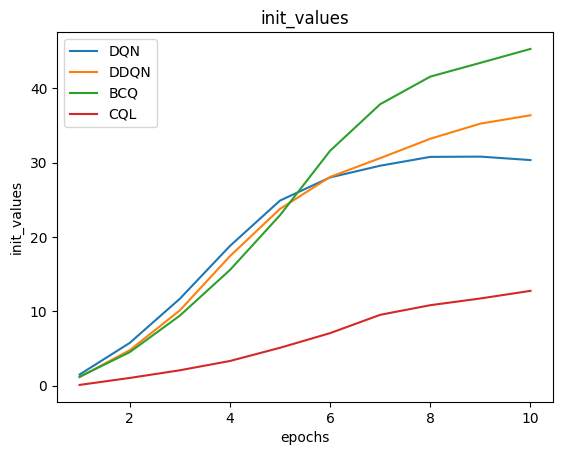

In [18]:
x = list(range(1, n_epochs+1))
for policy_info in evaluation_policies:
    policy = policy_info["name"]  # 获取策略名称
    plt.plot(x, init_values_dict[policy], label=policy)

plt.xlabel('epochs')
plt.ylabel('init_values')
plt.title('init_values')
plt.legend()
plt.show()

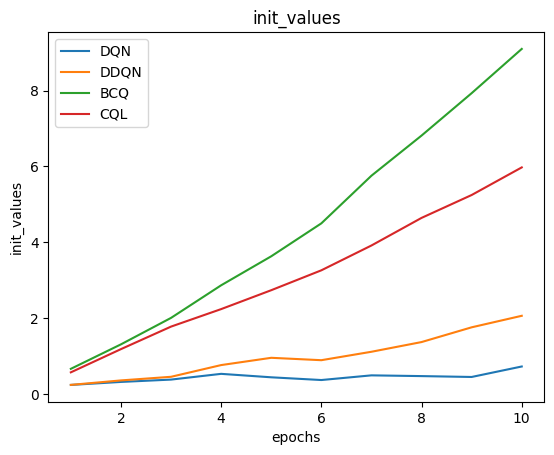

In [19]:
x = list(range(1, n_epochs+1))
for policy_info in evaluation_policies:
    policy = policy_info["name"]  # 获取策略名称
    plt.plot(x, soft_opcs_dict[policy], label=policy)

plt.xlabel('epochs')
plt.ylabel('init_values')
plt.title('init_values')
plt.legend()
plt.show()

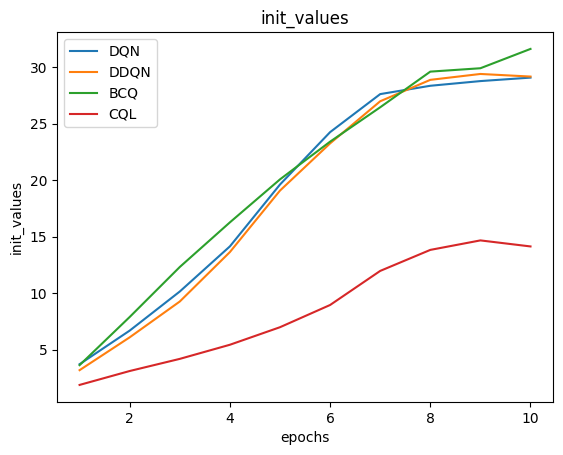

In [20]:
x = list(range(1, n_epochs+1))
for policy_info in evaluation_policies:
    policy = policy_info["name"]  # 获取策略名称
    plt.plot(x, average_value_dict[policy], label=policy)

plt.xlabel('epochs')
plt.ylabel('init_values')
plt.title('init_values')
plt.legend()
plt.show()

In [ ]:
x = list(range(1, n_epochs+1))
for policy_info in evaluation_policies:
    policy = policy_info["name"]  # 获取策略名称
    plt.plot(x, environment_dict[policy], label=policy)

plt.xlabel('epochs')
plt.ylabel('init_values')
plt.title('init_values')
plt.legend()
plt.show()

### 2.4 Validation
Now let's see if the training did something. If the results are not as expected try recording more data or increasing the training epochs.

In [14]:
env_show = Env(visible=True, level=str(level)).env

dqn = d3rlpy.algos.DQNConfig(learning_rate=learning_rate, gamma=gamma,
          target_update_interval=target_update_interval,
          batch_size=batch_size).create()
dqn.build_with_dataset(getDataset())

# dqn.load_model(model_file)
dqn.load_model("data\models\CQL_marioai_OneCliffLevel_0.99_0.0003_3000_10.pt")

try:
    while True:
        observation, _ = env_show.reset()

        done = False
        total_reward = 0
        while not done:
            predict_action = dqn.predict(observation[np.newaxis, :])[0]
            observation, reward, done, truncated, info = env_show.step(predict_action)
            total_reward += reward
        print(f'finished episode, total_reward: {total_reward}')
except ConnectionResetError:
    print("Window closed.") 

Running on port 61218


d:\marioai\marioenv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment Marioai-v0 is out of date. You should consider upgrading to version `v2`.
  logger.warn(


(200, 4)
D:\marioai\exercise_offline_rl\data\datasets\OneCliffLevel.h5
D:\marioai\exercise_offline_rl\data\datasets\RoughTerrainLevel.h5
observation_shape:  (800,)
dataset_info.action_size:  13


d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
d:\marioai\marioenv\lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


finished episode, total_reward: 25
Window closed.


In [40]:
env_show = Env(visible=True, level=str(level)).env

ddqn = d3rlpy.algos.DoubleDQNConfig(learning_rate=learning_rate, gamma=gamma,
          target_update_interval=target_update_interval,
          batch_size=batch_size).create()
ddqn.build_with_dataset(getDataset())

# dqn.load_model(model_file)
ddqn.load_model("data\models\DDQN_marioai_OneCliffLevel_0.99_0.0003_3000_10.pt")

try:
    while True:
        observation, _ = env_show.reset()

        done = False
        total_reward = 0
        while not done:
            predict_action = ddqn.predict(observation[np.newaxis, :])[0]
            observation, reward, done, truncated, info = env_show.step(predict_action)
            total_reward += reward
        print(f'finished episode, total_reward: {total_reward}')
except ConnectionResetError:
    print("Window closed.")

Running on port 55652
(200, 4)
D:\marioai\exercise_offline_rl\data\datasets\OneCliffLevel.h5
D:\marioai\exercise_offline_rl\data\datasets\OneCliffLevel.random.h5
observation_shape:  (800,)
dataset_info.action_size:  13
finished episode, total_reward: 34
finished episode, total_reward: 34
Window closed.


## 3. Offline RL vs Online RL 

Now we want to compare the approach from the first exercise where an online Q-Learner was used with the results we were able to achieve with the offline RL approach demonstrated above.

![Gif](https://1.bp.blogspot.com/-O0FvK3zJd9w/XpXqiJduwyI/AAAAAAAAFtM/5hxzdWOoSLw5sd5vEgMsiGVJSATKx1oEgCLcBGAsYHQ/s640/OFFLINE%2BRL%2Bfig1%2B05b.gif)


### 3.1 Reproducibility
To compare as fairly as possible we ran both the Online Q-Learner as well as the offline Deep Q-Network until a plateau of performance has been reached.
- The online Q-Learner was able to train for 10.000 episodes per level while being able to interact with the environment
- The DQN was fed <1 hour (~360 episodes) of human playtime per level and was not allowed to interact with the environment while training
- Both models were using the same reward settings


### 3.2 Easy level

|  | Reward | Video |
| -------- | -------- | -------- |
| Q-Learner  | 232     | ![Gif](https://raw.githubusercontent.com/koerners/marioai/master/exercise_offline_rl/data/jupyter/rough_terrain_q_learner_232.gif)    |
| Deep Q-Network  | 280    | ![Gif](https://raw.githubusercontent.com/koerners/marioai/master/exercise_offline_rl/data/jupyter/rough_terrain_dqn_280.gif)    |

With sufficient training, neither model struggles with the easy level. However, the model fed with player generated data shows better anticipation of jumps which leads to a better overall result.

### 3.3 Medium level

|  | Reward | Video |
| -------- | -------- | -------- |
| Q-Learner  | 176     | ![Gif](https://raw.githubusercontent.com/koerners/marioai/master/exercise_offline_rl/data/jupyter/cliff_and_enemies_q_learner_176.gif)    |
| Deep Q-Network  | 193    | ![Gif](https://raw.githubusercontent.com/koerners/marioai/master/exercise_offline_rl/data/jupyter/cliff_and_enemies_dqn_193.gif)    |

In the medium level, both models behave similarly to the easy level. While the Online Learner seems to have a better strategy to avoid enemies, the Offline Learner has the better jumping performance leading to a better overall score as it is quicker to finish the level.

### 3.4 Hard level
|  | Reward | Video |
| -------- | -------- | -------- |
| Q-Learner  | -559     | ![Gif](https://raw.githubusercontent.com/koerners/marioai/master/exercise_offline_rl/data/jupyter/climb_q_learner_-559.gif)    |
| Deep Q-Network  | -34    | ![Gif](https://raw.githubusercontent.com/koerners/marioai/master/exercise_offline_rl/data/jupyter/climb_dqn_-34.gif)    |

Neither model manages to complete the really hard level we tested them on. It is however interesting to observe the different strategies they applied. While the Q-Learner shows a very promising leap to the middle platform, failing to reach the final platform it seems to just give up and wait for the time to run out leading to a high time punishment and therefore an extremely low score. The offline trained model while still failing to complete the level, has developed a strategy to avoid the high time punishment by committing suicide as soon as possible.

### 3.5 Reward Summary

![Summary](https://raw.githubusercontent.com/koerners/marioai/master/exercise_offline_rl/data/jupyter/level-summary.png)




### 3.6 Performance over 100 levels

To compare how well the different methods are able to generalize, we let both the online Q-Learner and the offline DQN train on a single level (the easy level above) and then let them play 100 randomly generated levels (including the three levels above).

The model obtained by Q-Learning is only able to beat a single level (presumably the one it was trained on) which indicates that the model highly overfits the level used for training.

The model produced by the DQN using user-supplied data on the other hand is able to beat 12 out of the 100 levels and manages to obtain a positive reward on 21 of them. While that number may still not be terribly impressive, it shows that the offline approach is able to generalize good enough to beat levels it has never seen before and far surpasses what the Q-Learner was able to achieve.

The plot below shows the total reward achieved by the offline and online method for each level. Here we can also see that the offline method is usually able to obtain a higher reward than the online method. This means that either the offline agent is able to progress further into the level or that the online learner gets stuck somewhere while the offline learner prefers a quick death like in the hard level above.

![Comparison: Achieved Reward](https://raw.githubusercontent.com/koerners/marioai/master/exercise_offline_rl/data/jupyter/eval.png)


## 4. Conclusion

While achieving slightly better results than the online RL approach in the easy and medium level, the offline DQN approach was not able to perform any better than the online implementation in the hard level we tested them both on.
Our guess would be the lack of training data as mastering a level of this complexity would require a level of understanding of the environment that the network was not able to abstract from the data we were able to provide.
This also demonstrates the biggest issue with the offline RL approach: it's high dependence on good and plentiful data.
Creating such data is a time-consuming and often times an expensive endeavor.

Nevertheless, even with limited data the offline approach was still able to generalize better than the online approach, as we have learned from our evaluation on random levels.
We also believe that there is room to improve for the offline approach even without providing additional data.
For example, we expect that the training results with our limited amount of data might be improved by adding a Convolutional Neural Network to the DQN.
This might lead to a precise Pixel recognition of the matrix that our
agent perceives thus leading to better reactions in certain situations with the training data of one balanced level which the player faces different situation.


In the real world offline RL is often times the only sensible way to use an ML model as online learning would simply be too dangerous or slow. 
However, this comes with the price of the agent not being able to explore different approaches on its own meaning an often times subpar training result.
Companies like Tesla have acknowledged this issue and have been training their self-driving cars in a life like simulated environment in which they reproduce difficult situations the car might encounter to explore without any real world damages. [[3]](https://youtu.be/11QXiJ8ORe8?t=3187)

![Thanks](https://media4.giphy.com/media/1mssFONYwmBlJy1DAv/giphy.gif?cid=ecf05e47fq7b3e8nbn49rxb2hj1f8qy627umny603h7tsi8f&rid=giphy.gif&ct=g)